In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [20]:
from pathlib import Path

# data_folder = '../datasets/valid-fixed'
data_folder = '../datasets/train-fixed-whole/'
image_folder = f"{data_folder}/images"
masks_folder = f"{data_folder}/masks"
# files = [str(ss) for ss in sorted([s for s in Path(data_folder).glob('*.png')], key=lambda x: int(x.name.split('.')[0]))]
names = [Path(ss).name for ss in sorted([s for s in Path(image_folder).glob('*.png')], key=lambda x: int(x.name.split('.')[0]))]
image_files = [f"{image_folder}/{name}" for name in names]
mask_files = [f"{masks_folder}/{name}" for name in names]

In [21]:
import tensorflow as tf
import numpy as np
import segmentation_models as sm
from tensorflow.keras.models import load_model
sm.set_framework('tf.keras')

def load_model(checkpoint):
    model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=N_CLASSES, activation=ACTIVATION)
    model1.load_weights(checkpoint)
    return model1

N_CLASSES=2
ACTIVATION='softmax'

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# model1 = load_model('checkpoint_cleaning_aug_smarter_reduce_on_plat/resnet34_backbone_50epochs_bs1_lr0.0001.hdf5')
model2 = load_model('checkpoint_cleaning_aug_smarter_reduce_on_plat/resnet34_backbone_50epochs_bs4_lr0.0001.hdf5')
# model2 = load_model('checkpoint_predicted/resnet34_backbone_50epochs_bs1_lr0.0001.hdf5')

In [22]:
from typing import Tuple, List

def decode_img(filename, size=None, channels=3, interpolation='bicubic', antialias=True):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img, channels=channels)
    if size is not None:
        img = tf.image.resize(img, size, method=interpolation, antialias=antialias)
#     img = tf.clip_by_value(img, 0, 255)
#     img = tf.cast(img, dtype=tf.uint8)
    return img

def read_image(filename: str, size: Tuple[int,int]=None) -> tf.Tensor:
    return decode_img(filename, size, 3, interpolation='nearest', antialias=False)

def read_mask(filename, size=None):
    mask = decode_img(filename, size, 1, interpolation='nearest', antialias=False)
    mask = tf.cast(mask, tf.float32) / 255.
    mask = tf.squeeze(tf.cast(mask, tf.uint8))
    mask = tf.stack([1-mask, mask], axis=-1)
    return mask

def image_generator(image_files, mask_files, size_im, size_m=None, batch_size=1):
    def yieldify(ims, mas):
        return tf.stack(ims, axis=0),tf.stack(mas, axis=0)
    
    images = []
    masks = []
    for im, mas in zip(image_files, mask_files):
#         yield read_image(im, size_im), read_mask(mas, size_m)
        if len(images) >= batch_size:
            yield yieldify(images, masks)
            images = []
            masks = []
            
        images.append(read_image(im, size_im))
        masks.append(read_mask(mas, size_m))
            
    if len(images) != 0:
        yield yieldify(images, masks)
        
def predict_batch(batch, model):
    return model.predict(batch, batch_size=len(batch), verbose=0)

def postprocess_preds(masks, target_size):
    masks = tf.image.resize(masks, target_size, 'nearest')
#     print(masks.shape)
    masks = tf.argmax(masks, axis=-1) 
    masks = tf.clip_by_value(masks* 255, 0, 255)
    masks = tf.cast(masks, tf.uint8)
    return masks

In [23]:
from tqdm import tqdm
# preds1 = [model1(tensor[0]).numpy() for tensor in tqdm (image_generator(image_files, mask_files, (1024,1024), (1024,1024), batch_size=8))]
preds2 = [model2(tensor[0]).numpy() for tensor in tqdm (image_generator(image_files, mask_files, (1024,1024), (1024,1024), batch_size=16))]


0it [00:00, ?it/s]
1it [00:01,  1.84s/it]
2it [00:03,  1.69s/it]
3it [00:04,  1.58s/it]
4it [00:06,  1.52s/it]
5it [00:07,  1.53s/it]
6it [00:09,  1.51s/it]
7it [00:10,  1.49s/it]
8it [00:12,  1.46s/it]
9it [00:13,  1.46s/it]
10it [00:15,  1.50s/it]
11it [00:16,  1.54s/it]
12it [00:18,  1.49s/it]
13it [00:19,  1.49s/it]
14it [00:21,  1.48s/it]
15it [00:22,  1.46s/it]
16it [00:24,  1.46s/it]
17it [00:25,  1.51s/it]
18it [00:27,  1.50s/it]
19it [00:28,  1.48s/it]
20it [00:30,  1.52s/it]
21it [00:31,  1.59s/it]
22it [00:33,  1.56s/it]
23it [00:35,  1.56s/it]
24it [00:36,  1.57s/it]
25it [00:38,  1.55s/it]
26it [00:39,  1.53s/it]
27it [00:41,  1.50s/it]
28it [00:42,  1.52s/it]
29it [00:44,  1.52s/it]


In [24]:
# masks1 = [postprocess_preds(pred, (1232, 1624)).numpy() for pred in preds1]
masks = [postprocess_preds(pred, (1232, 1624)).numpy() for pred in preds2]

In [25]:
scores2 = []
for pred_masks, (_, gt_masks) in tqdm(zip(masks, image_generator(image_files, mask_files, (1024,1024), (1232, 1624), batch_size=16))):
    gt_masks = tf.cast(gt_masks, tf.float32)
    pred_masks_f = tf.cast(pred_masks,tf.float32)/255.0
    pred_masks_f = tf.stack([1-pred_masks_f, pred_masks_f], axis=-1)
#     scores.append(sm.metrics.f1_score(gt=gt_masks, pr=pred_masks_f).numpy())
    scores2 += [sm.metrics.f1_score(gt=gt_masks[i][tf.newaxis,], pr=pred_masks_f[i][tf.newaxis,]).numpy() for i in range(len(gt_masks))]
#     break
    
np.mean(scores2)


0it [00:00, ?it/s]
1it [00:01,  1.30s/it]
2it [00:02,  1.27s/it]
3it [00:03,  1.16s/it]
4it [00:04,  1.15s/it]
5it [00:05,  1.08s/it]
6it [00:06,  1.06s/it]
7it [00:07,  1.04s/it]
8it [00:08,  1.03s/it]
9it [00:09,  1.04s/it]
10it [00:10,  1.04s/it]
11it [00:11,  1.02s/it]
12it [00:12,  1.04s/it]
13it [00:13,  1.04s/it]
14it [00:14,  1.02s/it]
15it [00:15,  1.03s/it]
16it [00:16,  1.02s/it]
17it [00:17,  1.03s/it]
18it [00:18,  1.01s/it]
19it [00:19,  1.00s/it]
20it [00:20,  1.00s/it]
21it [00:22,  1.06s/it]
22it [00:23,  1.04s/it]
23it [00:24,  1.04s/it]
24it [00:25,  1.06s/it]
25it [00:26,  1.05s/it]
26it [00:27,  1.05s/it]
27it [00:28,  1.03s/it]
28it [00:29,  1.02s/it]
29it [00:30,  1.05s/it]


0.7994469

In [7]:
scores2 = []
for pred_masks, (_, gt_masks) in tqdm(zip(masks, image_generator(image_files, mask_files, (1024,1024), (1232, 1624), batch_size=16))):
    gt_masks = tf.cast(gt_masks, tf.float32)
    pred_masks_f = tf.cast(pred_masks,tf.float32)/255.0
    pred_masks_f = tf.stack([1-pred_masks_f, pred_masks_f], axis=-1)
#     scores.append(sm.metrics.f1_score(gt=gt_masks, pr=pred_masks_f).numpy())
    scores2 += [sm.metrics.f1_score(gt=gt_masks[i][tf.newaxis,], pr=pred_masks_f[i][tf.newaxis,]).numpy() for i in range(len(gt_masks))]
#     break
    
np.mean(scores2)

58it [00:28,  2.04it/s]


0.7994469

In [26]:
scores = scores2

In [27]:
scores = np.array(scores)
argsorted = np.argsort(scores)
lowers = np.where(scores < np.mean(scores))

In [28]:
import matplotlib.pylab as plt
from PIL import Image

def plot_side_by_side(image1: Image.Image, image2: Image.Image, figsize=(10,10)):
    fig, ax =plt.subplots(1,2, figsize=figsize)
    ax[0].axis('off')
    ax[0].imshow(np.asarray(image1))
    
    ax[1].axis('off')
    ax[1].imshow(np.asarray(image2))
    
    plt.tight_layout()
    plt.show()

In [29]:
flatten_masks = np.concatenate(masks, axis=0)

In [30]:
from PIL import ImageOps

class Images:
    def __init__(self, filenames: List[str]):
        self.filenames = filenames
        
    def __getitem__(self, index):
        return Image.open(self.filenames[index])
    
    def __len__(self):
        return len(self.filenames)
    
class Masks:
    def __init__(self, filenames: List[str]):
        self.filenames = filenames
        
    def __getitem__(self, index):
        return ImageOps.invert(Image.open(self.filenames[index]).convert('L'))
    
    def __len__(self):
        return len(self.filenames)
    
def overlay_mask(image, mask, color=(255,0,0)):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    if not isinstance(mask, Image.Image):
        mask = Image.fromarray(255-mask).convert('L')
        print(mask.size)
    return Image.composite(image, Image.new('RGB', image.size, color), mask)

In [31]:
all_images = Images(image_files)
all_masks = Masks(mask_files)

In [32]:
np.array(names)[argsorted[:50]]

array(['181.png', '586.png', '404.png', '198.png', '561.png', '179.png',
       '370.png', '771.png', '294.png', '646.png', '152.png', '269.png',
       '598.png', '653.png', '559.png', '642.png', '635.png', '301.png',
       '172.png', '377.png', '498.png', '579.png', '513.png', '540.png',
       '751.png', '569.png', '297.png', '442.png', '175.png', '223.png',
       '494.png', '500.png', '474.png', '761.png', '493.png', '213.png',
       '171.png', '488.png', '85.png', '562.png', '111.png', '530.png',
       '217.png', '677.png', '188.png', '506.png', '73.png', '51.png',
       '54.png', '409.png'], dtype='<U8')

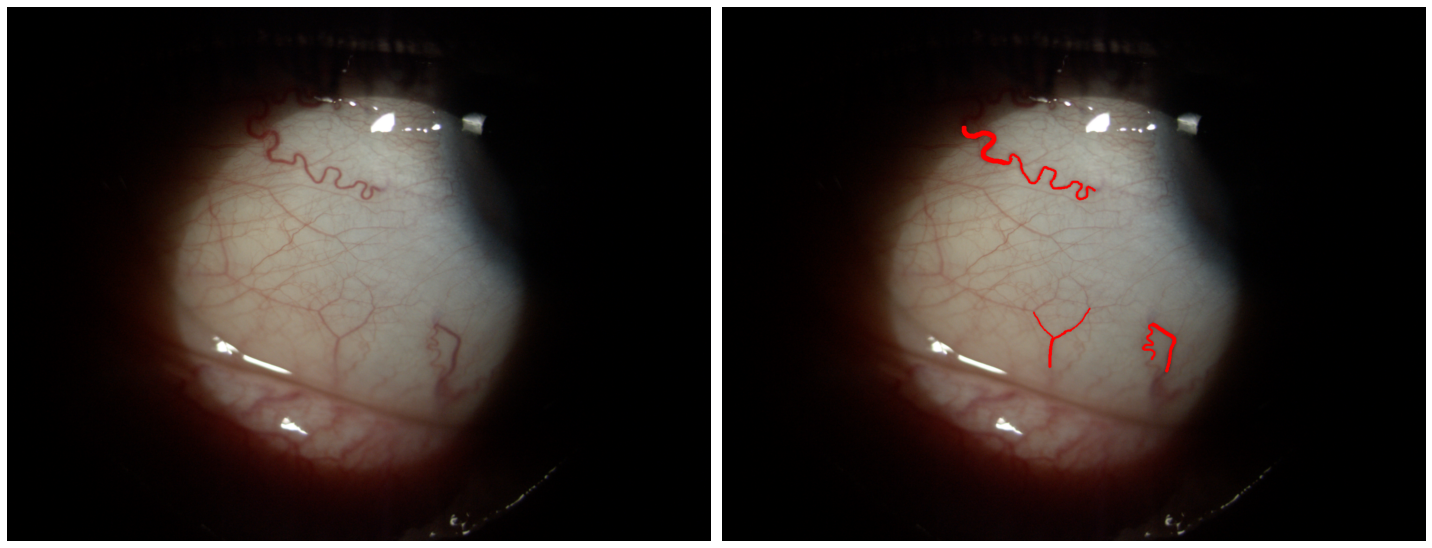

(1624, 1232)


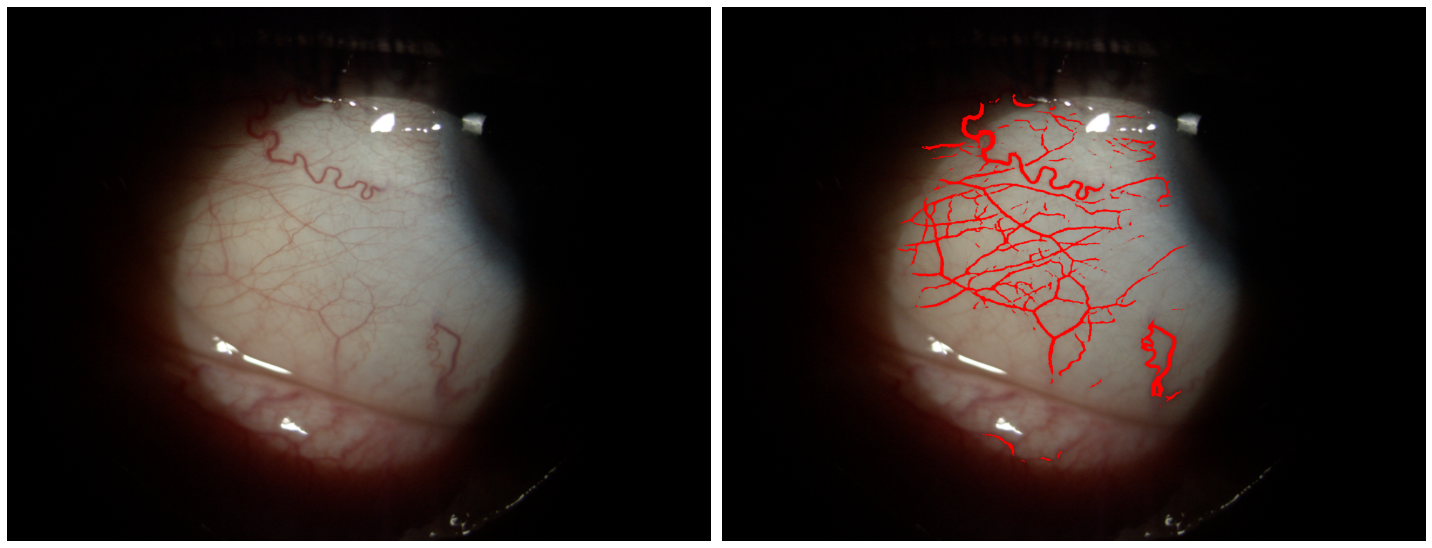

(1624, 1232)


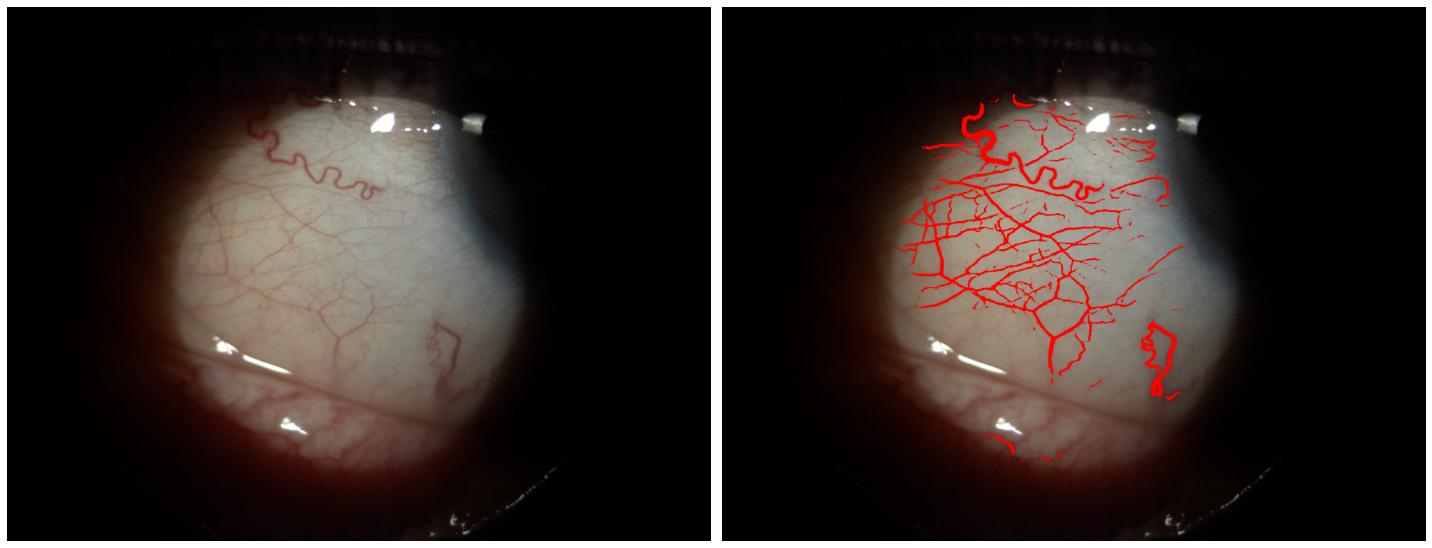

In [35]:
index = argsorted[2]
plot_side_by_side(all_images[index], overlay_mask(all_images[index], all_masks[index]), (20,20))
plot_side_by_side(all_images[index], overlay_mask(all_images[index], flatten_masks[index]), (20,20))
overlapped = overlap_masks([255-np.asarray(all_masks[index]), flatten_masks[index]])
plot_side_by_side(all_images[index], overlay_mask(all_images[index], overlapped), (20,20))

In [19]:
def overlap_masks(masks: List[np.ndarray]):
    return np.max(np.stack(masks,axis=-1), axis=-1)

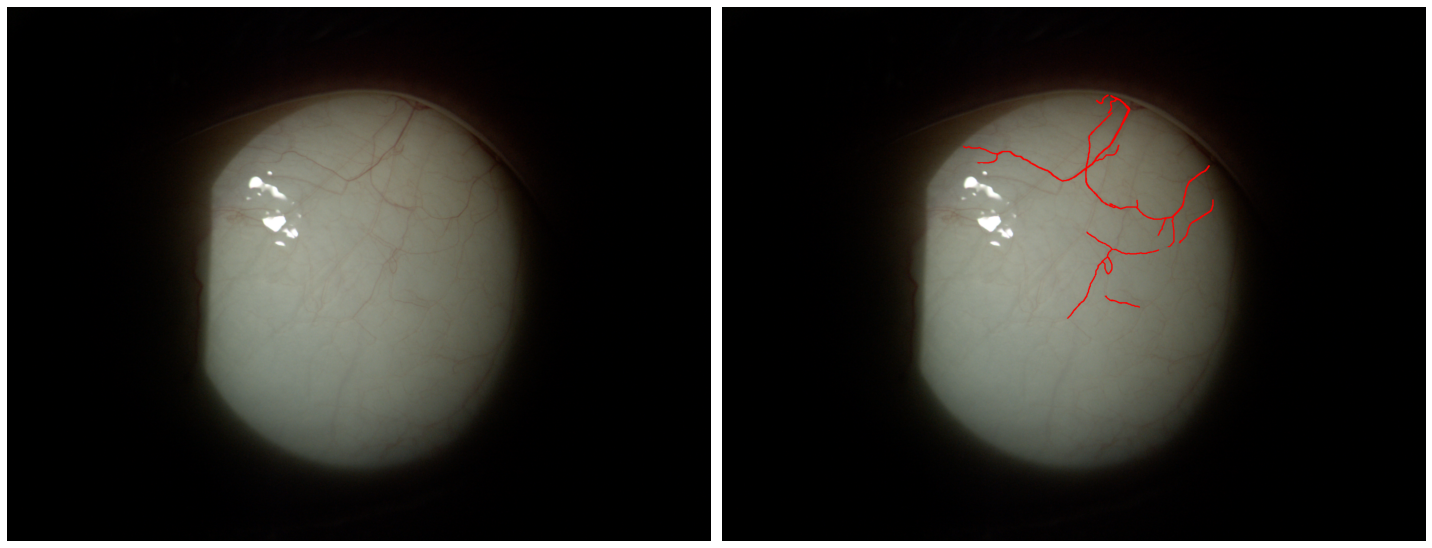

(1624, 1232)


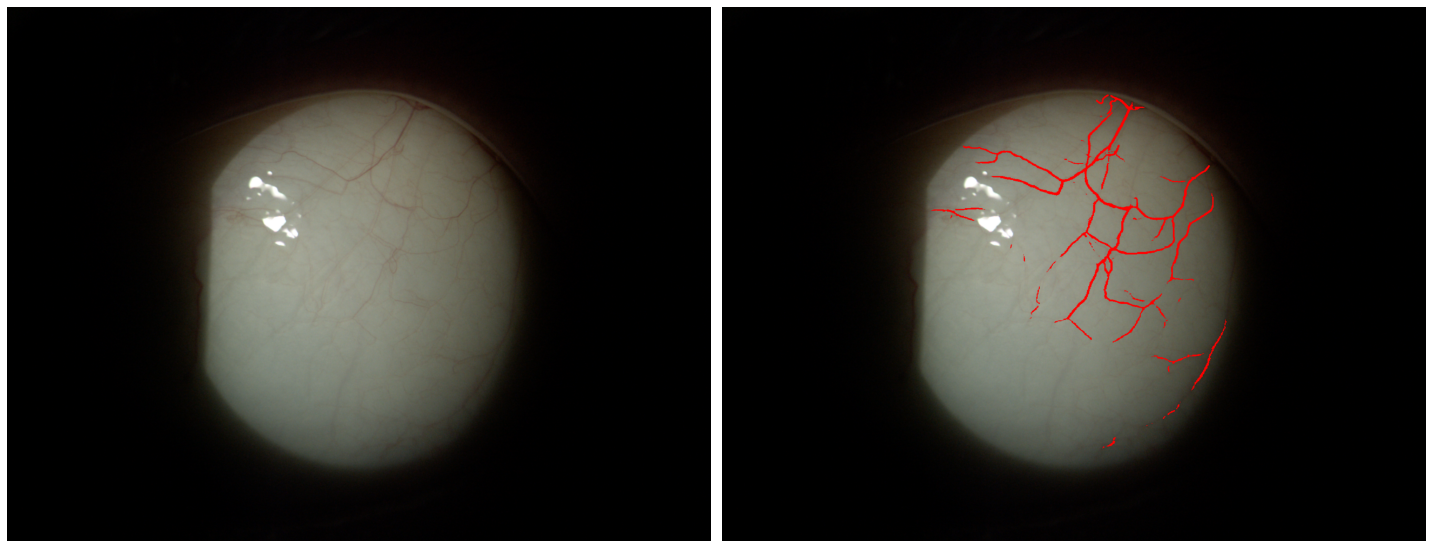

In [56]:
index = np.random.choice(argsorted[:200])
overlapped = overlap_masks([255-np.asarray(all_masks[index]), flatten_masks[index]])
plot_side_by_side(all_images[index], overlay_mask(all_images[index], all_masks[index]), (20,20))
plot_side_by_side(all_images[index], overlay_mask(all_images[index], overlapped), (20,20))

In [52]:
scores[argsorted][0]

0.4951345

In [37]:
for i in tqdm(argsorted[:200]):
    overlapped = Image.fromarray(overlap_masks([255-np.asarray(all_masks[i]), flatten_masks[i]]))
    overlapped.save(f'../datasets/train-predicted/masks/{names[i]}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.91it/s]
